1.0
0.9418286210196669
 52.932018 seconds (229.60 M allocations: 17.989 GiB, 5.76% gc time, 35.12% compilation time)


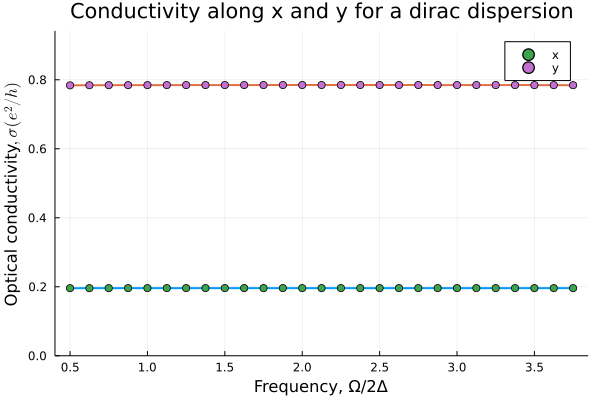

In [1]:
# using Printf
using Plots
using Roots
using DelimitedFiles
using LinearAlgebra
using HCubature
using LaTeXStrings
using TOML

const ħ=1


function δ(x,η)
    return (1/π)* η / (η^2 + x^2)
end

function fermi(x,β)
    return 1 / (1 + e^(β*x)) 
end

function Hamilt(K,param)
    kx = K[1] ; ky = K[2]
        H11 = 0
        H22 = H11
        H12 = param.Δ + ħ^2/(2*param.mx) * kx^2  +  ħ^2/(2*param.my) * ky^2  +  ħ*param.vx*kx - im*ħ*param.vy*ky
        H21 = conj(H12)
        H = [     H11         H12       ; 
                  H21         H22       ]     
    return H
end

function VelocityX(K,param)
    kx = K[1] ; ky = K[2]
    V11 = 0
    V22 = V11
    V12 =  ħ/param.mx * kx  +  param.vx
    V21 = conj(V12)
    V = [ V11  V12  ;
          V21  V22  ]
    return V
end

function VelocityY(K,param)
    kx = K[1] ; ky = K[2]
    V11 = 0
    V22 = V11
    V12 =  ħ/param.my * ky  - im*param.vy
    V21 = conj(V12)
    V = [ V11  V12  ;
          V21  V22  ]
    return V
end


function H(K,param)
    kx = K[1] ; ky = K[2]
    if dispersion in ["quadratic" "Quadratic"]
        H = [           0                                   param.Δ + ħ^2/(2*param.mx) * kx^2  +  ħ^2/(2*param.my) * ky^2 ; 
              param.Δ + ħ^2/(2*param.mx) * kx^2  +  ħ^2/(2*param.my) * ky^2                          0                     ]     * (1+0im)
    elseif dispersion in ["dirac" "Dirac"]
        H = [           0            ħ*param.vx*kx - im*ħ*param.vy*ky ; 
               ħ*param.vx*kx + im*ħ*param.vy*ky              0         ]
    elseif dispersion in ["semidirac" "Semidirac" "SemiDirac"]
        H = [           0                         param.Δ + ħ^2/(2param.mx)*kx^2 - im*ħ*param.vy*ky ; 
              param.Δ + ħ^2/(2param.mx)*kx^2 + im*ħ*param.vy*ky                      0               ]
    else
        error("Wrong keyword for dispersion")
    end
    return H
end

function E(K,param)
    kx = K[1] ; ky = K[2]
    if dispersion in ["quadratic" "Quadratic"]
         E = param.Δ + ħ^2/(2*param.mx) * kx^2  +  ħ^2/(2*param.my) * ky^2
    elseif dispersion in ["dirac" "Dirac"]
      #   E = ħ * sqrt(param.vx^2*kx^2 + param.vy^2*ky^2)
         E = eigvals(H(K,param))[2] 
    elseif dispersion in ["semidirac" "Semidirac" "SemiDirac"]
         E = sqrt( ( param.Δ + ħ^2/(2param.mx)*kx^2 )^2 + (ħ*param.vy*ky)^2 )
    else
        error("Wrong keyword for dispersion")
    end
    return E
end


function Vx(K,param)
    kx = K[1] ; ky = K[2]
    if dispersion in ["quadratic" "Quadratic"]
         Vx = [0  ħ/param.mx * kx ; ħ/param.mx * kx  0]
    elseif dispersion in ["dirac" "Dirac"]
         Vx = [0  param.vx ; param.vx  0]
    elseif dispersion in ["semidirac" "Semidirac" "SemiDirac" "Semi-Dirac" "semi-dirac" "semi-Dirac"]
         Vx = [0  ħ/param.mx * kx ; ħ/param.mx * kx  0]
    else
        error("Wrong keyword for dispersion")
    end
    return Vx
end


function Vy(K,param)
    kx = K[1] ; ky = K[2]
    if dispersion in ["quadratic" "Quadratic"]
         Vy = [0  ħ/param.my * ky ; ħ/param.my * ky  0]
    elseif dispersion in ["dirac" "Dirac"]
         Vy = [0  -im*param.vy ; im*param.vy  0]
    elseif dispersion in ["semidirac" "Semidirac" "SemiDirac" "Semi-Dirac" "semi-dirac" "semi-Dirac"]
         Vy = [0  -im*param.vy ; im*param.vy  0]
    else
        error("Wrong keyword for dispersion")
    end
    return Vy
end

function σ(Ω,param)  
    function kernel(K)
          E = eigvals(H(K,param))
          U = eigvecs(H(K,param))
          Velx = U'* Vx(K,param) * U
          Vely = U'* Vy(K,param) * U
          Vx2 = real(Velx[1,2]*Velx[2,1])
          Vy2 = real(Vely[1,2]*Vely[2,1])
          kern = 1 / (E[2]-E[1]) / (E[2]-E[1] - Ω - im*η)
          return [kern * Vx2 , kern * Vy2]
    end
Kmin = [0;0]
(cond,err) = hcubature(K -> kernel(K), Kmin, Kmax; norm=norm, rtol=rtl, atol=atl)
return imag.(cond) * 4*2pi /  (4π^2)
end


function σx(Ω,param) # ₓ  
    function integrandx(K)
          U = eigvecs(H(K,param))
          Velx = U'* Vx(K,param) * U
          Vx2 = real(Velx[1,2]*Velx[2,1])
          return 1/(2*E(K,param)) * Vx2 / (2*E(K,param) - Ω - im*η) 
    end
Kmin = [0;0] ;  #  Kmax = find_Kmax(Ωmax,param)  #[kxmax;kymax]
(condx,err) = hcubature(K -> integrandx(K), Kmin, Kmax; norm=norm, rtol=rtl, atol=atl)

return imag(condx) * 4*2pi /  (4π^2)
end

function σy(Ω,param)
    function integrandy(K)
      U = eigvecs(H(K,param))
      Vely = U'* Vy(K,param) * U
      Vy2 = real(Vely[1,2]*Vely[2,1])
      return 1/(2*E(K,param)) * Vy2 / (2*E(K,param) - Ω - im*η) 
    end
Kmin = [0;0] ;    #Kmax = find_Kmax(Ωmax,param) 
(condy,err) = hcubature(K -> integrandy(K), Kmin, Kmax; norm=norm, rtol=rtl, atol=atl)
return imag(condy) * 4*2pi /  (4π^2)
end

function find_Kmax(Ωmax,param)
    epsilon = 1e-5
    factor = 1 -η * log(epsilon) #  cuts off Fermi tails smaller than epsilon
    if dispersion in ["quadratic" "Quadratic"]
         kxmax = sqrt(factor*(Ωmax/2 - param.Δ))*sqrt(2*param.mx) / ħ   ;  kymax = sqrt(factor*(Ωmax/2 - param.Δ))*sqrt(2*param.my) / ħ
    elseif dispersion in ["dirac" "Dirac"]
         kxmax = factor*(Ωmax/2) / (param.vx*ħ)   ;   kymax = factor*(Ωmax/2) / (param.vy*ħ) 
    elseif dispersion in ["semidirac" "Semidirac" "SemiDirac" "Semi-Dirac" "semi-dirac" "semi-Dirac"]
         kxmax = sqrt(factor*(Ωmax/2 - param.Δ))*sqrt(2param.mx) / ħ  ;  kymax = factor*(Ωmax/2) / (param.vy*ħ) 
    else
        error("Wrong keyword for dispersion")
    end
    return [kxmax,kymax]
end

function find_kmax(Ωmax,param)
    epsilon = 1e-5
    factor = 1 -η * log(epsilon) #  cuts off Fermi tails smaller than epsilon
    function fx(k)
        f = eigmax(H([k,0],param)) - factor*Ωmax/2
        return f
    end
    function fy(k)
        f = eigmax(H([0,k],param)) - factor*Ωmax/2
    return f
    end
    kxmax = find_zero(fx, 0)
    kymax = find_zero(fy, 0)
    return [kxmax,kymax]
end
    

struct MatConst
    mx::Float64
    my::Float64
    vx::Float64
    vy::Float64    
    Δ::Float64
end

function main()
input = TOML.parsefile("conf.toml")
global η = input["eta"]
global dispersion = input["dispersion"]
global (rtl, atl) = [input["rtol"], input["atol"]]
param = MatConst(input["mx"], input["my"], input["vx"], input["vy"], input["halfgap"])
println(param.mx)
Δ = param.Δ
(dΩ, Ωmax, Ωmin) = [input["dW"], input["Wmax"], input["Wmin"]]
#global Kmax = find_Kmax(Ωmax,param)
global Kmax = find_kmax(Ωmax,param)

#
    cond = [σ(Ω,param) for Ω = Ωmin : dΩ : Ωmax]
    (condx,condy) = (hcat(cond...)[1,:] , hcat(cond...)[2,:] )  # reshaping
    #
    Ω = Ωmin : dΩ : Ωmax
    open("conductivity.dat", "w") do io
        writedlm(io, [Ω/(2Δ) condx condy])
    end
    #
    ylimmax = maximum([condx;condy]) *1.2
    println(ylimmax)
    G_const=0.8346268
 #   println((pi*G_const/6)*3/G_const/sqrt(2))
#    kxmax = sqrt(Ω - Δ)*sqrt(2mx) / ħ
#    specfun = [A(kx,0.0,ω)[1,2] for ω = -Ω : dω : +Ω, kx = 0 : kxmax * (1/nkx) : kxmax]
#    w= -Ω : dω : +Ω
#    kx = 0 : kxmax * (1/nkx) : kxmax
#    heatmap(kx,w,specfun)
    Ω = Ωmin : dΩ : Ωmax
    plot(Ω/(2Δ), condx,lw=2,xlabel="Frequency, Ω/2Δ",ylabel="Optical conductivity"*L", σ (e^2/h)", label="", ylim=(0,ylimmax))
    plot!(Ω/(2Δ), condy,lw=2, label="")
    plot!(Ω/(2Δ), condx, seriestype=:scatter, lw=2, label="x")
    plot!(Ω/(2Δ), condy, seriestype=:scatter, lw=2, label="y")
    title!("Conductivity along x and y for a $dispersion dispersion")
end


@time begin

    main()

end